In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 


## simulaciones

In [ ]:

# cargo simulaciones de temperatura y precipitacion que salen del bootstrap
sim_temp_csv = '../outputs/bootstrap_results/daily_simulations_temperature.csv'
sim_precip_csv = '../outputs/bootstrap_results/daily_simulations_precipitation.csv'

sim_temp = pd.read_csv(sim_temp_csv)
sim_precip = pd.read_csv(sim_precip_csv)

sim_df = pd.concat([
    sim_temp.add_prefix('temp_'),
    sim_precip.add_prefix('precip_')
], axis=1)

n_sims = len([col for col in sim_df.columns if col.startswith('temp_')])

sim_dfs = []

for i in range(n_sims):
    sim_num = f'{i:04d}'
    temp_col = f'temp_sim_{sim_num}'
    precip_col = f'precip_sim_{sim_num}'
    
    sim_data = pd.DataFrame({
        'temperature': sim_df[temp_col],
        'precipitation': sim_df[precip_col]
    })
    
    sim_data['simulation'] = i
    
    sim_dfs.append(sim_data)

sim_df_reshaped = pd.concat(sim_dfs, axis=0).reset_index(drop=True)

print(sim_df_reshaped.head())

print(sim_df_reshaped.tail())

   temperature  precipitation  simulation
0    24.062653       0.000065           0
1    22.432343       0.000039           0
2    21.985382       0.000309           0
3    22.916473       0.000195           0
4    25.023071       0.000083           0
        temperature  precipitation  simulation
364995    27.403473       0.000373         999
364996    27.566559       0.000267         999
364997    28.369050       0.000194         999
364998    27.613434       0.000473         999
364999    27.734283       0.000212         999


In [ ]:
# --- Definir umbrales dinámicos ---
threshold_precipitation = np.percentile(sim_df_reshaped['precipitation'], 75)
threshold_temperature = 25

print("p75_precip:", threshold_precipitation)
print("threshold_temp:", threshold_temperature)

# --- Condiciones diarias ---
sim_df_reshaped['cond_precip'] = (sim_df_reshaped['precipitation'] > threshold_precipitation).astype(int)
sim_df_reshaped['cond_temp']   = (sim_df_reshaped['temperature']   < threshold_temperature).astype(int)
sim_df_reshaped['cond_both']   = (sim_df_reshaped['cond_precip'].eq(1) &
                                  sim_df_reshaped['cond_temp'].eq(1)).astype(int)

# --- Función: marca 1 en TODAS las posiciones que pertenezcan a corridas de True con largo >= min_len ---
def _mark_runs(series, min_len=3):
    cond = series.astype(bool)
    runs = (cond != cond.shift()).cumsum()
    run_sizes = cond.groupby(runs).transform('size')
    return ((cond) & (run_sizes >= min_len)).astype(int)

# --- Eventos por simulación (corridas de >=3 días) ---
sim_df_reshaped['precip_event'] = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_precip'].apply(_mark_runs)
sim_df_reshaped['temp_event']   = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_temp'].apply(_mark_runs)
sim_df_reshaped['event']        = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_both'].apply(_mark_runs)

# --- Pérdidas diarias (100 por día con evento) ---
sim_df_reshaped['loss_precip'] = 100 * sim_df_reshaped['precip_event']
sim_df_reshaped['loss_temp']   = 100 * sim_df_reshaped['temp_event']
sim_df_reshaped['loss']        = 100 * sim_df_reshaped['event']      # ambas a la vez

# --- Chequeo rápido ---
total_dias = len(sim_df_reshaped)

frac_precip = sim_df_reshaped['precip_event'].sum() / total_dias
frac_temp   = sim_df_reshaped['temp_event'].sum()   / total_dias
frac_both   = sim_df_reshaped['event'].sum()        / total_dias

print("\nFracción de días con evento (respecto al total):")
print(f"Precipitación: {frac_precip:.3%}")
print(f"Temperatura:   {frac_temp:.3%}")
print(f"Ambos (event): {frac_both:.3%}")

p75_precip: 0.000749588
threshold_temp: 25

Fracción de días con evento (respecto al total):
Precipitación: 13.538%
Temperatura:   2.210%
Ambos (event): 0.086%


In [27]:
# --- Resumen por simulación ---
summary_by_sim = sim_df_reshaped.groupby('simulation').agg({
    'precip_event': 'sum',
    'temp_event': 'sum',
    'event': 'sum',
    'loss_precip': 'sum',
    'loss_temp': 'sum',
    'loss': 'sum'
})

# --- Estadísticas básicas ---
summary_stats = summary_by_sim.mean().to_frame("Media")
summary_stats["Mediana"] = summary_by_sim.median()
summary_stats["Máximo"] = summary_by_sim.max()
summary_stats["Mínimo"] = summary_by_sim.min()

print("\nPromedio de eventos y pérdidas anuales por simulación:")
print(summary_stats)


Promedio de eventos y pérdidas anuales por simulación:
                 Media  Mediana  Máximo  Mínimo
precip_event    49.432     49.0     108      19
temp_event       3.664      3.0      16       0
event            0.193      0.0       4       0
loss_precip   4943.200   4900.0   10800    1900
loss_temp      366.400    300.0    1600       0
loss            19.300      0.0     400       0


In [3]:
# --------------------------------------------------------------------------------
# DEFINICIÓN ORIGINAL DE EVENTO (ya no se usa, reemplazada por la nueva lógica)
#
# Un evento se definía como un día con:
#   - temperatura > threshold_temperature
#   - precipitación > threshold_precipitation
#
# Luego se calculaba:
#   - probabilidad de evento (proporción de días con evento sobre días sin evento)
#   - cantidad total de eventos
# --------------------------------------------------------------------------------

# threshold_precipitation = 0.003
# threshold_temperature = 13
#
# sim_df_reshaped['event'] = np.where(
#     (sim_df_reshaped['temperature'] > threshold_temperature) &
#     (sim_df_reshaped['precipitation'] > threshold_precipitation),
#     1, 0
# )
#
# print("probabilidad de evento", np.round(
#     sim_df_reshaped['event'].value_counts()[1] /
#     sim_df_reshaped['event'].value_counts()[0] * 100, 3
# ))
#
# print("Cantidad de eventos", sim_df_reshaped['event'].value_counts())
# sim_df_reshaped['loss'] = 1000  # por dia de HW y de pps pierdo 1000 pesos (por evento)
# sim_df_reshaped['loss'] = sim_df_reshaped['loss'] * sim_df_reshaped['event']


In [ ]:
# --- Curva AEP usando "loss" (AMBAS) ---
def build_aep(loss_series, label):
    s = loss_series.sort_values(ascending=False).reset_index(drop=True)
    n = len(s)
    ex_prob = [(i)/(n+1)*100 for i in range(1, n+1)]    # 100/(n+1) es la probabilidad de excedencia
    return pd.DataFrame({'Loss': s, 'Exceedance_Probability': ex_prob, 'Type': label})

aep_both   = build_aep(summary_by_sim['loss'], "Ambas")
aep_precip = build_aep(summary_by_sim['loss_precip'], "Precipitación")
aep_temp   = build_aep(summary_by_sim['loss_temp'], "Temperatura")

aep_all = pd.concat([aep_precip, aep_temp, aep_both], ignore_index=True)


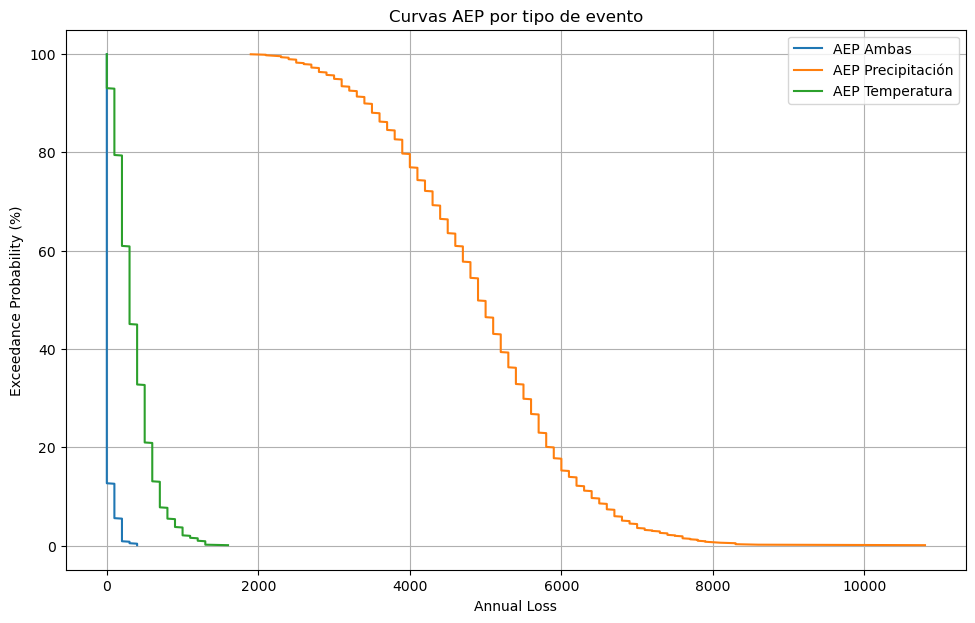

In [37]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes([0.05, 0.05, 0.9, 0.9])
for name, df in aep_all.groupby('Type'):
    ax.plot(df['Loss'], df['Exceedance_Probability'], label=f"AEP {name}")
ax.grid(True)
ax.set_ylabel('Exceedance Probability (%)')
ax.set_xlabel('Annual Loss')
ax.set_title('Curvas AEP por tipo de evento')
ax.legend()


## observadas

In [ ]:
# --- Cargar observados ---
df_observed = pd.read_csv('../outputs/tulum_temp_precip_timeseries.csv')

# --- Definir umbrales ---
p75_precip = np.percentile(df_observed['precipitation'], 75)
threshold_temp = 25

# --- Condiciones diarias ---
df_observed['cond_precip'] = (df_observed['precipitation'] > p75_precip).astype(int)
df_observed['cond_temp']   = (df_observed['tmin'] < threshold_temp).astype(int)
df_observed['cond_both']   = (df_observed['cond_precip'] & df_observed['cond_temp']).astype(int)

# --- Función: marcar corridas de >= min_len ---
def _mark_runs(series, min_len=3):
    cond = series.astype(bool)
    runs = (cond != cond.shift()).cumsum()
    run_sizes = cond.groupby(runs).transform('size')
    return ((cond) & (run_sizes >= min_len)).astype(int)

# --- Detectar eventos (corridas de al menos 3 días) ---
df_observed['precip_event'] = _mark_runs(df_observed['cond_precip'], min_len=3)
df_observed['temp_event']   = _mark_runs(df_observed['cond_temp'], min_len=3)
df_observed['event']        = _mark_runs(df_observed['cond_both'], min_len=3)

# --- Pérdidas ---
df_observed['loss_precip'] = 100 * df_observed['precip_event']
df_observed['loss_temp']   = 100 * df_observed['temp_event']
df_observed['loss']        = 100 * df_observed['event']

# --- Año calendario ---
df_observed['year'] = pd.to_datetime(df_observed['date']).dt.year

# --- Pérdidas anuales ---
yearly_loss_observed = df_observed.groupby('year')[['loss_precip','loss_temp','loss']].sum()

yearly_loss_observed.describe()


,loss_precip,loss_temp,loss
count,11.000000,11.000000,11.000000
mean,5172.727273,13300.000000,936.363636
std,2213.635430,2604.227333,656.159626
min,1200.000000,8300.000000,300.000000
25%,4050.000000,12150.000000,550.000000
50%,5000.000000,13100.000000,700.000000
75%,6950.000000,14850.000000,1100.000000
max,8200.000000,17500.000000,2600.000000


,loss_precip,loss_temp,loss
count,11.000000,11.000000,11.000000
mean,5172.727273,21081.818182,2618.181818
std,2213.635430,3660.004968,1486.484566
min,1200.000000,12100.000000,300.000000
25%,4050.000000,20250.000000,1650.000000
50%,5000.000000,21700.000000,2400.000000
75%,6950.000000,22450.000000,3250.000000
max,8200.000000,26000.000000,5800.000000


## Autocorrelaciones

In [ ]:
# Extract day of year from date column
df_observed['doy'] = pd.to_datetime(df_observed['date']).dt.dayofyear

# Calculate daily climatology (mean temperature for each day of year)
climatology = df_observed.groupby('doy')['tmin'].mean()

# Calculate anomalies by subtracting climatology from actual temperatures
temperature_anomalies = df_observed.apply(lambda x: x['tmin'] - climatology[x['doy']], axis=1)

climatology_precip = df_observed.groupby('doy')['precipitation'].mean()

precipitation_anomalies = df_observed.apply(lambda x: x['precipitation'] - climatology_precip[x['doy']], axis=1)



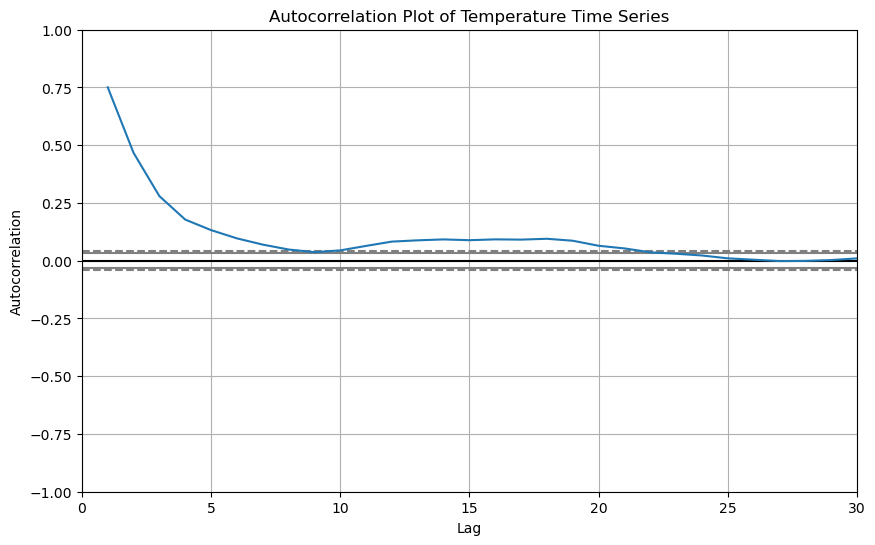

In [9]:
# Create autocorrelation plot
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(temperature_anomalies)
plt.grid(True)
plt.title('Autocorrelation Plot of Temperature Time Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(0, 30)
plt.show()

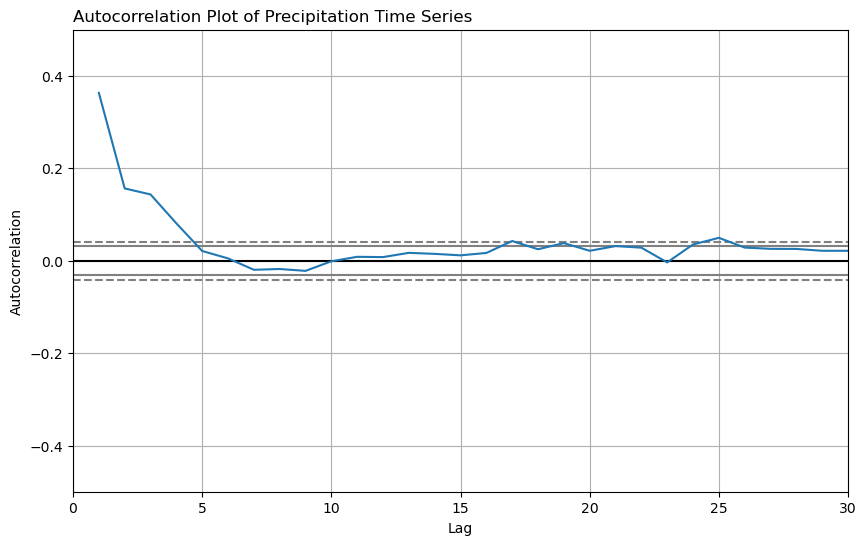

In [10]:
# Create autocorrelation plot
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(precipitation_anomalies)
plt.grid(True)
plt.title('Autocorrelation Plot of Precipitation Time Series', loc='left')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(0, 30)
plt.ylim(-0.5, 0.5)
plt.show()